In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

from PIL import Image

import os
import random
from imutils import paths
from collections import defaultdict 
import numpy as np
import time
import argparse

from itertools import cycle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

### Fixing Random Seeds

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Initializing parameters

In [3]:
CROSS_VAL_DIR = '../data/cross_validation'
MODEL_SAVE_DIR = '../trained_models'
#N_EPOCHS = 5
N_EPOCHS = 20
FOLD = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LR = 1e-4
BATCH_SIZE = 16
IMG_WIDTH, IMG_HEIGHT = 224, 224
MODEL_NAME = 'vgg16'

## The VGG_16 Model

In [4]:
class VGG16_model(nn.Module):
    def __init__(self,
                 input_size: tuple = (3, 224, 224),
                 hidden_size: int = 64,
                 dropout: float = 0.5,
                 num_classes: int = 3,
                 **kwargs
                ):
        """
        Initialize a new network
        
        Inputs: 
        - input_size: Tuple, size of input data
        - hidden_size: Integer, number of units to use in hidden layer
        - dropout: Float, dropout coefficient
        - num_classes: Integer, number of classes
        """
        
        super(VGG16_model, self).__init__()
        
        # load the VGG16 network
        self.model = models.vgg16(pretrained=True)

        # freeze weights of base model except last cnn layer
        # model.parameters() does not include max pooling layers
        last_frozen = 25
        count = 0
        for param in self.model.parameters():
            count += 1
            if count < last_frozen:
                param.requires_grad = False
                
        # Taking only sequential part
        self.model = self.model.features
    
        self.avgpool = nn.AvgPool2d(4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, hidden_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self,x):
        x = self.model(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn(x) 
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## The Pocovid Dataset Class

In [5]:
class PocovidDataset(Dataset):
    """Subclass of Dataset for POCOVID-Net data"""
  
    def __init__(self, data_path_info, transform=None):
        """
        Args:
          data_path_info (dict): Dictionary containing the paths and labels for images
          transform (callable, optional): Optional transform to be applied
              on a sample.
        """
        self.__transform = transform
        
        self.__covid_class = 0
        self.__pneu_class = 1
        self.__regular_class = 2

        covid_items = []
        pneu_items = []
        regular_items = []

        for i in range(len(data_path_info['path_list'])):
            if(data_path_info['label_list'][i] == 'covid'):
                covid_items.append(data_path_info['path_list'][i])
            elif(data_path_info['label_list'][i] == 'pneumonia'):
                pneu_items.append(data_path_info['path_list'][i])
            else:
                regular_items.append(data_path_info['path_list'][i])

        num_covid = 0
        num_pneu = 0
        num_regular = 0 
        
        self.__img_info = []
        for covid_filename in covid_items: 
            image = Image.open(covid_filename)
            to_tensor_tsfm = ToTensor()
            im_tensor = to_tensor_tsfm(image)
            if im_tensor.shape[0] == 3:
                self.__img_info.append((covid_filename,self.__covid_class))
                num_covid += 1
            
        for pneu_filename in pneu_items:
            image = Image.open(pneu_filename)
            to_tensor_tsfm = ToTensor()
            im_tensor = to_tensor_tsfm(image)
            if im_tensor.shape[0] == 3:
                self.__img_info.append((pneu_filename,self.__pneu_class))
                num_pneu += 1
                
        for regular_filename in regular_items:
            image = Image.open(regular_filename)
            to_tensor_tsfm = ToTensor()
            im_tensor = to_tensor_tsfm(image)
            if im_tensor.shape[0] == 3:
                self.__img_info.append((regular_filename,self.__regular_class)) 
                num_regular += 1

        self.__transform = transform
        self.__num_images = num_covid + num_pneu + num_regular
  
    def __len__(self):
        return self.__num_images
  
    def __getitem__(self,idx):
        img_name, img_class = self.__img_info[idx]
        image = Image.open(img_name)
        sample = [image, img_class]

        if self.__transform:
            sample = [self.__transform(image), img_class]

        return sample
    
    def get_covid_class_idx(self):
        return self.__covid_class
    
    def get_pneu_class_idx(self):
        return self.__pneu_class
    
    def get_regular_class_idx(self):
        return self.__regular_class
    
    def get_class_map(self):
        class_map = {self.get_covid_class_idx() : 'covid',
            self.get_pneu_class_idx() : 'pneumonia',
            self.get_regular_class_idx() : 'regular'}
        return class_map

## The Training Class

In [6]:
class Trainer():
    
    def __init__(self, model_name=MODEL_NAME, lr=LR, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, 
                 image_width=IMG_WIDTH, image_height=IMG_HEIGHT, cross_val_dir=CROSS_VAL_DIR,
                model_save_dir=MODEL_SAVE_DIR, fold=FOLD):
        
        if(model_name=='vgg16'):
            self.model = VGG16_model().to(device)
        elif(model_name=='resnet18'):
            self.model = resnet18_model().to(device)
        else:
            print('Select models from the following:\n 1) vgg16\n 2) resnet50')
                    
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.fold = fold
        self.cross_val_dir = cross_val_dir
        
        self.image_width = image_width
        self.image_height = image_height
        
        self.criterion = nn.CrossEntropyLoss().to(device)
        self.optimizer = optim.Adam(params = self.model.parameters(), lr=self.lr) #experiment with weigth_decay
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.95) # use scheduler
        
        self.model_save_dir = model_save_dir
        self.model_name = model_name
        
        self.train_loader = None
        self.test_loader = None
        
        self.classes = None
        self.class_map = None
        
        
    def get_train_test_info(self):
        """
        Get information dictionaries for train and test data
        """
    
        imagePaths = list(paths.list_images(self.cross_val_dir))

        train_path_info = defaultdict(list)
        test_path_info = defaultdict(list)

        for imagePath in imagePaths:
            path_parts = imagePath.split(os.path.sep)
            fold_number = path_parts[-3][-1]
            label = path_parts[-2]
            if(fold_number==str(self.fold)):
                test_path_info['path_list'].append(imagePath)
                test_path_info['label_list'].append(label)
            else:
                train_path_info['path_list'].append(imagePath)
                train_path_info['label_list'].append(label)

        return train_path_info, test_path_info
    
    
    def get_train_test_loaders(self, num_workers=2):
        
        """
        Get the train and test data according to the fold
        """
        
        train_path_info, test_path_info = self.get_train_test_info()

        train_transform = transforms.Compose([transforms.Resize((self.image_width, self.image_height)),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.RandomVerticalFlip(),
                                              transforms.RandomAffine(10,translate=(0.1,0.1)),
                                              transforms.ToTensor()])

        test_transform = transforms.Compose([transforms.Resize((self.image_width, self.image_height)),
                                           transforms.ToTensor()])

        trainset = PocovidDataset(train_path_info, transform = train_transform)
        testset = PocovidDataset(test_path_info, transform = test_transform)
        
        self.class_map = trainset.get_class_map()
        self.classes = [self.class_map[key] for key in sorted(self.class_map)]

        train_loader = torch.utils.data.DataLoader(trainset, num_workers=num_workers, shuffle=True,
                                          batch_size=self.batch_size, drop_last=True)

        test_loader = torch.utils.data.DataLoader(testset, num_workers=num_workers, shuffle=True,
                                        batch_size=self.batch_size)
        
        return train_loader, test_loader
    
    def train(self, iterator):
        """
        The train function
        """
    
        self.model.train()

        epoch_loss = 0

        for i, batch in enumerate(iterator):

            inputs, labels = batch[0].to(device), batch[1].to(device)

            self.optimizer.zero_grad()

            outputs = self.model(inputs)

            loss = self.criterion(outputs, labels)

            loss.backward()

            self.optimizer.step()

            epoch_loss += loss.item()

        return epoch_loss / len(iterator)

    def evaluate(self, iterator):
        """
        The eval function
        """
    
        self.model.eval()

        epoch_loss = 0

        with torch.no_grad():    
            for i, batch in enumerate(iterator):    

                inputs, labels = batch[0].to(device), batch[1].to(device)

                outputs = self.model(inputs)

                loss = self.criterion(outputs, labels)

                epoch_loss += loss.item()

        return epoch_loss / len(iterator)
    
    def epoch_time(self, start_time, end_time):
        """
        The utility function to measure the time taken by an epoch to run
        """
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs
    
    def training(self):
        """
        The training function which does the training by calling train and eval functions
        """
    
        best_valid_loss = np.inf
        c = 0
        
        self.train_loader, self.test_loader = self.get_train_test_loaders()
        
        # Create the model save dir if it already doesn't exist
        if not os.path.exists(self.model_save_dir):
            os.makedirs(self.model_save_dir)
        
        for epoch in range(self.n_epochs):

            print(f'Epoch: {epoch+1:02}')

            start_time = time.time()

            train_loss = self.train(self.train_loader)
            valid_loss = self.evaluate(self.test_loader)

            epoch_mins, epoch_secs = self.epoch_time(start_time, time.time())

            c+=1
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(self.model.state_dict(), os.path.join(self.model_save_dir, '{}_trained.pt'.format(self.model_name)))
                c=0

            if c>4:
                #decrease lr if loss does not decrease after 5 steps
                self.scheduler.step()
                c=0

            print(f'Time: {epoch_mins}m {epoch_secs}s') 
            print(f'Train Loss: {train_loss:.3f}')
            print(f'Val   Loss: {valid_loss:.3f}')
            print('-'*100)
        print(best_valid_loss)
        
    def evaluate_model(self, iterator=None, proba=False, one_batch=False):
        
        if iterator is None:
            iterator = self.test_loader
    
        self.model.eval()

        images = []
        true_labels = []
        pred_labels = []
        pred_probs = []

        with torch.no_grad():    
            for i, batch in enumerate(iterator):    

                inputs, labels = batch[0].to(device), batch[1].to(device)

                outputs = self.model(inputs)

                y_prob = F.softmax(outputs, dim = -1)

                top_preds = y_prob.argmax(1, keepdim = True)

                images.append(inputs.to(device))
                true_labels.append(labels.to(device))
                pred_labels.append(top_preds.to(device))
                pred_probs.append(y_prob.to(device))

                if(one_batch):
                    break

        images = torch.cat(images, dim=0)
        true_labels = torch.cat(true_labels, dim=0)
        pred_labels = torch.cat(pred_labels, dim=0)
        pred_probs = torch.cat(pred_probs, dim=0)

        if(proba):
            return images, true_labels, pred_labels, pred_probs

        return images, true_labels, pred_labels
    
    def visualize_test_samples(self):
    
        images, true_labels, pred_labels, pred_probs = self.evaluate_model(proba=True, one_batch=True)

        true_labels = true_labels.cpu().numpy()
        pred_labels = pred_labels.cpu().numpy()
        pred_probs = pred_probs.cpu().numpy()


        rows = int(np.sqrt(len(images)))
        cols = int(np.sqrt(len(images)))

        fig = plt.figure(figsize = (25, 20))

        for i in range(rows*cols):

            ax = fig.add_subplot(rows, cols, i+1)

            image, true_label, pred_label, pred_prob = images[i], true_labels[i], pred_labels[i], pred_probs[i]
            image = image.permute(1, 2, 0)
            ax.imshow(image.cpu().numpy())
            ax.set_title(f'true label: {self.class_map[true_label]}\n' \
                        f'pred label: {self.class_map[pred_label[0]]} (Prob: {max(pred_prob):.3f})',
                        color = ('green' if true_label==pred_label[0] else 'red'))
            ax.axis('off')

        fig.subplots_adjust(hspace = 0.4)

        plt.show()
        
    def start_training(self):
        """
        To start trainig, evaluate the trained model and print the metrics
        """
        self.training()
        
        images, true_labels, pred_labels, pred_probs = self.evaluate_model(proba=True)
        
        metrics = Metrics(images, true_labels, pred_labels, pred_probs, self.classes)

        cm = metrics.get_confusion_matrix()
        print('The confusion matrix is:\n', cm)
        
        cr = metrics.get_classification_report()
        print('The classification report is:\n', cr)
        
        print('ROC Curves:')
        metrics.get_roc_curves()

## The Trained Model Class

In [7]:
class TrainedModel():
    
    def __init__(self, model_name='vgg16'):
        """
        To get the details of the pre-trained model
        """
        trainer = Trainer(model_name=model_name)
        self.model = trainer.model
        self.model_save_dir = trainer.model_save_dir
        self.model_name = model_name
        
    def loadModel(self):
        """
        To load the pre trained model
        """
        self.model.load_state_dict(torch.load(os.path.join(self.model_save_dir, '{}_trained.pt'.format(self.model_name)), map_location=torch.device(device)))
        return self.model
    
    def countParameters(self):
        """
        To get the number of trainable parameters of the model
        """
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)
    
    def printModel(self):
        """
        To print the network architecture
        """
        print(self.model)

## The Metrics Class

In [8]:
from sklearn.preprocessing import label_binarize

In [9]:
class Metrics():
    
    def __init__(self, images, true_labels, pred_labels, pred_probs, classes):

        self.images = images
        self.true_labels = true_labels
        self.pred_labels = pred_labels
        self.pred_probs = pred_probs
        self.classes = classes
        
    def plot_confusion_matrix(self):
        fig = plt.figure(figsize = (10, 10));
        ax = fig.add_subplot(1, 1, 1);
        cm = self.get_confusion_matrix()
        cm = ConfusionMatrixDisplay(cm, display_labels = self.classes);
        cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
        plt.xticks(rotation = 20)
    
    def get_confusion_matrix(self):
        cm = confusion_matrix(self.true_labels.cpu().numpy(), self.pred_labels.cpu().numpy())
        return cm
        
    def get_classification_report(self):
        cr = classification_report(self.true_labels.cpu().numpy(), self.pred_labels.cpu().numpy(), target_names=self.classes)
        return cr
    
    def get_roc_curves(self):
        # Based off example from: 
        # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        y = label_binarize(self.true_labels.cpu().numpy(), classes=[0, 1, 2])
        for i in range(len(self.classes)):
            fpr[i], tpr[i], _ = roc_curve(y[:, i], self.pred_probs.cpu().numpy()[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), self.pred_probs.cpu().numpy().ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(self.classes))]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(self.classes)):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= len(self.classes)

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                     ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                     ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        
        for i, color in zip(range(len(self.classes)), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(self.classes[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc="lower right")
        plt.show()

## Training

### Run the training

In [12]:
trainer = Trainer()
# having access to the trainer is useful for visualization, but for visualization, we can just load an
# already-trained model, so I have this commented out below. 
# trainer.start_training() 

## Visualization

In [10]:
trained_model = TrainedModel()
nathans_vgg = trained_model.loadModel()

### Fetch sample input
We're not augmenting this data becuase we want to see how the neural network behaves with real data as input.

In [13]:
train_path_data, test_path_data = trainer.get_train_test_info()
vis_transform = transforms.Compose([transforms.Resize((trainer.image_width, trainer.image_height)),
                                    transforms.ToTensor()])

visset = PocovidDataset(test_path_data, transform = vis_transform)

In [14]:
dataloader = torch.utils.data.DataLoader(visset, batch_size=4, shuffle=True, num_workers=2)

In [15]:
covid_idx = visset.get_covid_class_idx();
pneu_idx = visset.get_pneu_class_idx();
regular_idx = visset.get_regular_class_idx();
lbl_map = {covid_idx:"COVID",pneu_idx:"Pneumonia",regular_idx:"Regular"} 

# based on show_landmarks_batch() in the official PyTorch dataloader tutorial
def show_labeled_images_batch(sample_batched):
  """Show image with class labels for a batch of samples."""
  images_batch, classes_batch = sample_batched[0], sample_batched[1]
  batch_size = len(images_batch)
  assert images_batch.size(2) == images_batch.size(3)   # assume images are square
  im_width = images_batch.size(2) 
  grid_border_size = 2

  labels = [lbl_map[i.item()] for i in classes_batch]
  title_str = 'From left: ' + ', '.join(labels)
  plt.title(title_str)
  
  grid = torchvision.utils.make_grid(images_batch)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.title(title_str)

In [16]:
def get_sample_batch(sample_idx):

  for i_batch, sample_batched in enumerate(dataloader):
      # observe 4th batch, visualize images, and stop
      if i_batch == sample_idx:
          plt.figure()

          show_labeled_images_batch(sample_batched)
          plt.axis('off')
          plt.ioff()
          plt.show()
          return sample_batched

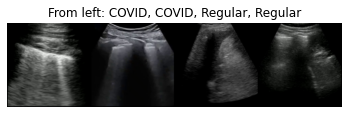

In [43]:
test_sample = get_sample_batch(sample_idx=3)

### Saliency maps

In [44]:
import sys
sys.path.append("util")
import vizutils

In [45]:
sample_images, sample_classes = test_sample[0], test_sample[1]

In [61]:
test_batch_idx = 2

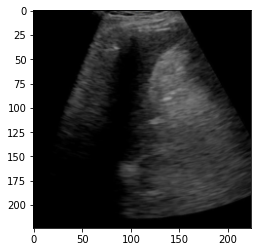

In [62]:
plt.imshow(sample_images[test_batch_idx].detach().numpy().transpose(1,2,0))

In [63]:
X = sample_images.cuda().detach()
y = sample_classes.cuda().detach()

In [64]:
saliency = vizutils.compute_saliency_maps(X, y, 3, nathans_vgg)

tensor([[ 3.7029, -1.7144, -1.9651],
        [ 2.5393,  0.2583, -2.5465],
        [-1.6789, -1.3509,  1.9686],
        [-1.3516,  0.3932,  0.4703]], device='cuda:0', grad_fn=<AddmmBackward>)


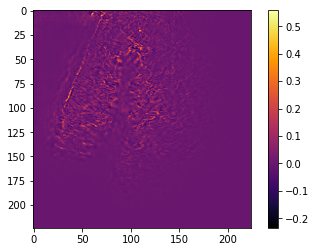

In [65]:
saliency_np = saliency.cpu().numpy()
plt.imshow(saliency_np[test_batch_idx], cmap=plt.cm.inferno)
plt.colorbar()